# Part 1 · Feature Engineering & Data Cleaning
Objective: convert raw OHLCV files into a high-quality feature store for the later modeling/backtesting stages while documenting the checks applied to the anonymized universe.

In [1]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src import config, data_loader, features

pd.set_option("display.max_columns", 50)
sns.set_theme(style="whitegrid")
config.ensure_directories()

{'artifacts': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts'),
 'feature_store': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/features'),
 'models': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/models'),
 'plots': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/plots'),
 'reports': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/reports')}

## 1. Universe ingestion & health checks
Load every asset file, then compute quick quality diagnostics (coverage, missingness, zero-volume bars).

In [2]:
raw_panel = data_loader.load_price_panel(config.DATA_DIR)
quality = data_loader.assess_data_quality(raw_panel)
pd.DataFrame({"metric": quality.keys(), "value": quality.values()})

,metric,value
0,rows,251100
1,assets,100
2,date_start,2016-01-25 00:00:00
3,date_end,2026-01-16 00:00:00
4,missing_ratio,"{'Date': 0.0, 'Open': 0.0, 'High': 0.0, 'Low':..."
5,zero_volume_days,1


## 2. Cleaning logic
1. Deduplicate per (date, asset) pair.
2. Winsorize extreme daily jumps (median absolute deviation based).
3. Interpolate over business days and repair zero-volume records.

In [3]:
clean_panel = data_loader.clean_price_panel(raw_panel)
clean_panel.head()

/home/navey/precogquanttask/model_pipeline/src/data_loader.py:77: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  g = g.interpolate(method="time").ffill().bfill()
/home/navey/precogquanttask/model_pipeline/src/data_loader.py:77: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  g = g.interpolate(method="time").ffill().bfill()
/home/navey/precogquanttask/model_pipeline/src/data_loader.py:77: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  g = g.interpolate(method="time").ffill().bfill()
/home/navey/precogquanttask/model_pipeline/src/data_loader.py:77: FutureWarning: DataFrame.interpolate with object dtype is deprecated and 

,Date,Open,High,Low,Close,Volume,Asset
0,2016-01-25,29.178415,29.181290,28.514486,28.580592,249449990.0,Asset_001
1,2016-01-26,28.721415,28.994458,28.186822,28.738659,361581962.0,Asset_001
2,2016-01-27,27.603374,27.772948,26.827351,26.850345,642328247.0,Asset_001
3,2016-01-28,26.956690,27.166502,26.554308,27.042913,268157355.0,Asset_001
4,2016-01-29,27.244108,27.977016,27.117645,27.977016,310239413.0,Asset_001


In [4]:
asset_lengths = clean_panel.groupby('Asset')['Date'].agg(['min', 'max', 'count'])
asset_lengths.rename(columns={'count': 'obs'}).head()

,min,max,obs
Asset,,,
Asset_001,2016-01-25,2026-01-16,2605
Asset_002,2016-01-25,2026-01-16,2605
Asset_003,2016-01-25,2026-01-16,2605
Asset_004,2016-01-25,2026-01-16,2605
Asset_005,2016-01-25,2026-01-16,2605


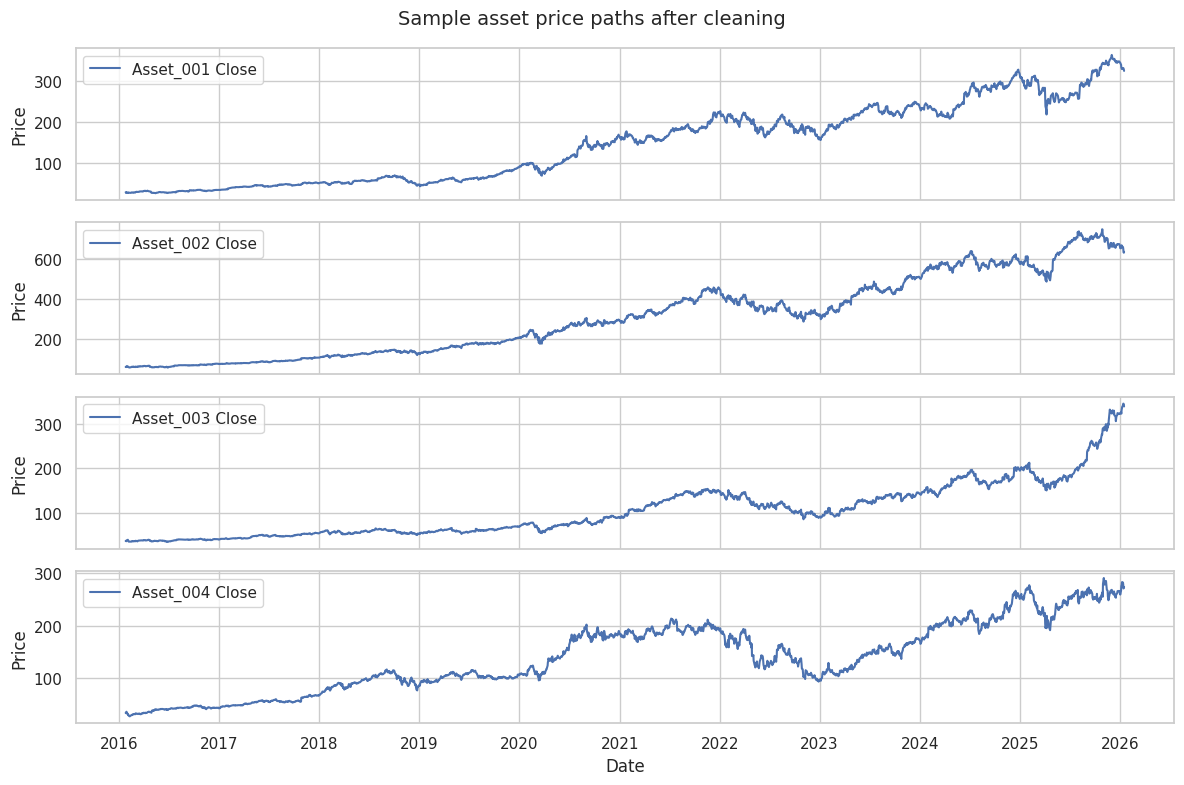

In [6]:
sample_assets = clean_panel['Asset'].unique()[:4]
fig, axes = plt.subplots(len(sample_assets), 1, figsize=(12, 8), sharex=True)
for ax, asset in zip(axes, sample_assets):
    asset_df = clean_panel[clean_panel['Asset'] == asset]
    ax.plot(asset_df['Date'], asset_df['Close'], label=f'{asset} Close')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')
axes[-1].set_xlabel('Date')
fig.suptitle('Sample asset price paths after cleaning', fontsize=14)
plt.tight_layout()

## 3. Alpha-oriented feature generation
Momentum, volatility, liquidity, and location/mean-reversion signals are computed per asset, with cross-sectional normalization to keep features comparable across the universe.

In [7]:
feature_cfg = features.FeatureConfig()
feature_matrix = features.build_feature_matrix(clean_panel, feature_cfg)
features.persist_feature_matrix(feature_matrix)
feature_matrix.head()

Open       High        Low      Close       Volume  \
Date       Asset                                                                
2017-01-11 Asset_001  34.887014  35.236649  34.845881  35.183763  132870787.0   
           Asset_002  78.092359  78.865673  77.867848  78.815781   15817576.0   
           Asset_003  41.093443  41.254245  40.908140  41.241992   28034792.0   
           Asset_004  45.403470  45.737563  45.166057  45.710105   43426705.0   
           Asset_005   3.418645   3.425095   3.358980   3.391553  402647906.0   

                        ret_1d    mom_1d    ret_3d    mom_3d    ret_5d  \
Date       Asset                                                         
2017-01-11 Asset_001  0.005373  0.005373  0.015605  0.015605  0.032150   
           Asset_002  0.009102  0.009102  0.005570  0.005570  0.014286   
           Asset_003  0.003877  0.003877  0.002183  0.002183  0.026700   
           Asset_004  0.003920  0.003920  0.003807  0.003807  0.055258   
           Asset_005 -0.012304 -0.012304  0.019981  0.019981  0.007376   

                        mom_5d   ret_10d   mom_10d   ret_21d   mom_21d  \
Date       Asset                                                         
2017-01-11 Asset_001  0.032150  0.025608  0.025608  0.039587  0.039587   
           Asset_002  0.014286  0.003175  0.003175  0.003334  0.003334   
           Asset_003  0.026700  0.029119  0.029119  0.014835  0.014835   
           Asset_004  0.055258  0.034826  0.034826  0.031872  0.031872   
           Asset_005  0.007376 -0.037437 -0.037437  0.153450  0.153450   

                       ret_63d   mom_63d  ann_vol_5d  ann_vol_10d  \
Date       Asset                                                    
2017-01-11 Asset_001  0.023249  0.023249    0.062498     0.086354   
           Asset_002  0.107922  0.107922    0.089624     0.101296   
           Asset_003  0.037738  0.037738    0.110938     0.137129   
           Asset_004 -0.029090 -0.029090    0.219721     0.221608   
           Asset_005  0.595961  0.595961    0.409382     0.426740   

                      ann_vol_21d  ann_vol_63d  vol_z_5d  vol_z_20d  \
Date       Asset                                                      
2017-01-11 Asset_001     0.072907     0.152175 -0.011573   0.050988   
           Asset_002     0.106945     0.180959  0.021793   0.011203   
           Asset_003     0.109275     0.178959 -0.179155  -0.153162   
           Asset_004     0.173101     0.252818 -0.281047  -0.110205   
           Asset_005     0.496045     0.721254 -0.363600  -0.512555   

                            rsi       atr      macd  macd_signal  macd_hist  \
Date       Asset                                                              
2017-01-11 Asset_001  76.212090  0.385626  0.419205     0.370889   0.048316   
           Asset_002  44.915435  0.928556  0.465525     0.607907  -0.142381   
           Asset_003  63.313702  0.502820  0.329882     0.240822   0.089060   
           Asset_004  68.007456  0.736017  0.370570     0.106428   0.264141   
           Asset_005  47.709675  0.177768  0.095689     0.129871  -0.034182   

                      price_distance_20  close_location  intraday_range  \
Date       Asset                                                          
2017-01-11 Asset_001           2.447916        0.364662        0.011214   
           Asset_002           0.610898        0.449999        0.012814   
           Asset_003           1.670963        0.464599        0.008461   
           Asset_004           1.838306        0.451955        0.012653   
           Asset_005          -0.198603       -0.007318        0.019683   

                      momentum_21d  momentum_63d  momentum_126d  \
Date       Asset                                                  
2017-01-11 Asset_001      0.039587      0.023249       0.211744   
           Asset_002      0.003334      0.107922       0.205752   
           Asset_003      0.014835      0.037738       0.096274   
           Asset_004    

In [8]:
feature_cols = [c for c in feature_matrix.columns if c not in ('fwd_return_1d', 'fwd_return_5d')]
feature_summary = feature_matrix[feature_cols].describe().T[['mean', 'std', 'min', 'max']].sort_values('std', ascending=False)
feature_summary.head(12)

,mean,std,min,max
Volume,1.597200e+07,4.543352e+07,37171.000000,2.828708e+09
High,1.829553e+02,2.312263e+02,3.139111,3.821525e+03
Close,1.810927e+02,2.288312e+02,3.083569,3.806153e+03
Open,1.810672e+02,2.287698e+02,3.100361,3.805550e+03
Low,1.791438e+02,2.262880e+02,3.073235,3.735480e+03
rsi,5.364795e+01,1.730274e+01,0.000000,1.000000e+02
atr,4.105600e+00,5.846183e+00,0.065645,1.506507e+02
macd,6.650618e-01,5.287039e+00,-114.373881,1.423657e+02
macd_signal,6.613118e-01,4.937994e+00,-98.450487,1.271203e+02
macd_hist,3.749950e-03,1.671996e+00,-51.575097,4.628972e+01


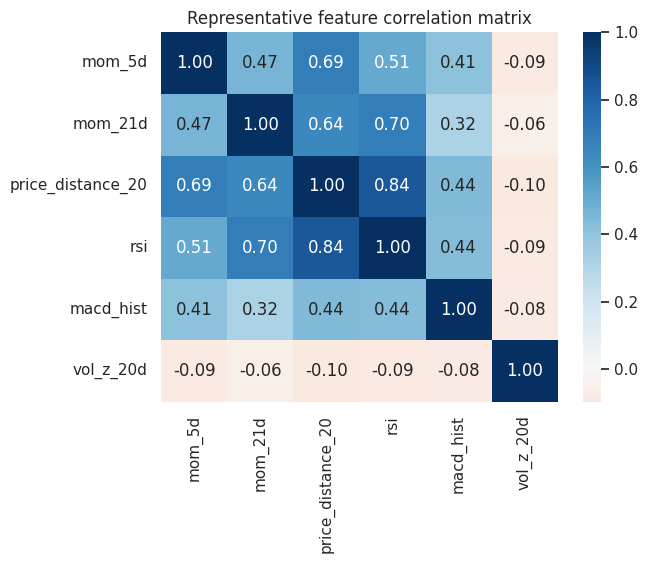

In [9]:
corr_sample = feature_matrix[['mom_5d', 'mom_21d', 'price_distance_20', 'rsi', 'macd_hist', 'vol_z_20d']].corr()
sns.heatmap(corr_sample, annot=True, cmap='RdBu', center=0, fmt='.2f')
plt.title('Representative feature correlation matrix')
plt.show()